# MTA Exploratory Data Analysis

Prepared by : Rania Almneie

## Goal

Exploratory data analysis on MTA data to  aid Moburst Advertising company:
- Determine where the three animated billboards will be located.
- Knowing how much the advertisement will cost over the course of the week, based on the number of visitors on each day.

## Data Description

To fulfill the project goal, I analyzed the data of the MTA, namely the following features (C/A, UNIT, SCP, STATION, DATE, TIME, ENTRIES) . Additionally, I obtained MTA data via the MTA website.  I used data from July 03, 2021 to October 02, 2021, totaling 2934629 observations.

## Moburst Project Consists of Four Main Steps:

### 1.Start with a question

- Will the EDA assists Moburst Advertising in reaching its goal? 


### 2.Collect and clean data

* Collect the data:

In [181]:
import pandas as pd
import datetime

dates=[210710,210717,210724,210731,210807,
       210814,210821,210828,210904,210911,210918,210925,211002]

df=pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_210703.txt')
for i in dates:
    temp= pd.read_csv(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{i}.txt")
    df= pd.concat([df, temp])
    
#See first 5 rows
df.head();

* Ingesting the raw data into a SQL database :

In [182]:
from sqlalchemy import *
engine=create_engine('sqlite:///MTA.db')
df.to_sql('MTA_data',engine,if_exists='replace',index=False)

In [189]:
#To check if the MTA_data table existing
tables=engine.table_names()
print(all_tables);

['MTAdata']


<ipython-input-189-e7fdfb96e717>:2: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  tables=engine.table_names()


* Querying from that database into Python via SQLAlchemy :

In [190]:
df=pd.read_sql('select * from MTA_data',engine)
df.shape

(2934629, 11)

In [191]:
#To check the type of df
type(df)

pandas.core.frame.DataFrame

* Clean the data:
      
      -Method preprocess is to do some pre process steps :

In [192]:
def preprocess(df):
    
    #Standardize column name
    df.columns = df.columns.str.strip()
    
    #Create date_time column from 'DATE' and 'TIME' cols
    df['date_time'] = pd.to_datetime(df.DATE + ' ' + df.TIME,format="%m/%d/%Y %H:%M:%S")
    
    #Drop unnecessary columns
    df=df.drop(['EXITS','DESC','DIVISION','LINENAME','TIME'], axis=1,errors="ignore")
    
    return df
    

df= preprocess(df)
df.head()   

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,date_time
0,A002,R051,02-00-00,59 ST,06/26/2021,7592792,2021-06-26 00:00:00
1,A002,R051,02-00-00,59 ST,06/26/2021,7592804,2021-06-26 04:00:00
2,A002,R051,02-00-00,59 ST,06/26/2021,7592816,2021-06-26 08:00:00
3,A002,R051,02-00-00,59 ST,06/26/2021,7592870,2021-06-26 12:00:00
4,A002,R051,02-00-00,59 ST,06/26/2021,7592992,2021-06-26 16:00:00


    -Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique :

In [193]:
(df
.groupby(["C/A", "UNIT", "SCP", "STATION", "date_time"])
.ENTRIES.count()
.reset_index()
.sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,date_time,ENTRIES
2911468,S101,R070,00-00-02,ST. GEORGE,2021-09-15 08:00:00,2
2911391,S101,R070,00-00-02,ST. GEORGE,2021-09-02 20:00:00,2
2911401,S101,R070,00-00-02,ST. GEORGE,2021-09-04 12:00:00,2
2911400,S101,R070,00-00-02,ST. GEORGE,2021-09-04 08:00:00,2
2911398,S101,R070,00-00-02,ST. GEORGE,2021-09-04 00:00:00,2


    So there are a duplicate entries !!

    -Get rid of the duplicate entry :

In [194]:
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "date_time"], 
                         inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "date_time"], inplace=True)

    -Sanity Check again to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique :

In [195]:
(df
.groupby(["C/A", "UNIT", "SCP", "STATION", "date_time"])
.ENTRIES.count()
.reset_index()
.sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,date_time,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-06-26 00:00:00,1
1956336,R139,R031,04-00-01,34 ST-PENN STA,2021-09-01 08:00:00,1
1956316,R139,R031,04-00-01,34 ST-PENN STA,2021-08-29 00:00:00,1
1956317,R139,R031,04-00-01,34 ST-PENN STA,2021-08-29 04:00:00,1
1956318,R139,R031,04-00-01,34 ST-PENN STA,2021-08-29 08:00:00,1


## 3.Exploratory data analysis (EDA)

In [198]:
#To see the shape of df
df.shape

(2934482, 7)

In [199]:
#To check missings with .info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2934482 entries, 2934628 to 0
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   C/A        object        
 1   UNIT       object        
 2   SCP        object        
 3   STATION    object        
 4   DATE       object        
 5   ENTRIES    int64         
 6   date_time  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 179.1+ MB


In [200]:
#check missings with .isna() then apply sum()
df.isna().sum()


#If we have a Missing Values we will handle it using one of 3 Methods

#1-Drop rows with missing values
#df.dropna()
#2-Fill missing values with a standard value such as zero
#df.ENTRIES.fillna(0)
#3-Impute missings with mean or median
#df.ENTRIES.fillna(df.ENTRIES.mean())

C/A          0
UNIT         0
SCP          0
STATION      0
DATE         0
ENTRIES      0
date_time    0
dtype: int64

In [206]:
df.describe()

,ENTRIES
count,2.934482e+06
mean,4.147925e+07
std,2.181698e+08
min,0.000000e+00
25%,2.201922e+05
50%,1.395819e+06
75%,5.997482e+06
max,2.147407e+09


In [ ]:
#To see the uniqe  values in STATION column
df.STATION.unique()

In [208]:
#To display the first 5 rows :
df.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,date_time
2934628,TRAM2,R469,00-05-01,RIT-ROOSEVELT,10/01/2021,5554,2021-10-01 21:00:00
2934627,TRAM2,R469,00-05-01,RIT-ROOSEVELT,10/01/2021,5554,2021-10-01 17:00:00
2934626,TRAM2,R469,00-05-01,RIT-ROOSEVELT,10/01/2021,5554,2021-10-01 13:00:00
2934625,TRAM2,R469,00-05-01,RIT-ROOSEVELT,10/01/2021,5554,2021-10-01 09:00:00
2934624,TRAM2,R469,00-05-01,RIT-ROOSEVELT,10/01/2021,5554,2021-10-01 05:00:00


In [209]:
#To take a sample from df
df.sample(5)

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,date_time
1089643,J021,R434,00-00-00,VAN SICLEN AV,08/03/2021,102675,2021-08-03 21:00:00
2717135,R623,R061,00-00-01,NOSTRAND AV,09/22/2021,458096,2021-09-22 08:00:00
1789467,N604,R342,00-03-00,JAMAICA VAN WK,08/25/2021,1398900,2021-08-25 13:00:00
998752,R236,R045,00-00-04,GRD CNTRL-42 ST,07/25/2021,12523761,2021-07-25 05:00:00
1309104,N049,R084,01-03-00,59 ST COLUMBUS,08/09/2021,10755097,2021-08-09 00:00:00


    -To sort the values based on C/A, UNIT, SCP, STATION, date_time :

In [210]:
df=df.sort_values(["C/A", "UNIT", "SCP", "STATION", "date_time"])

    -To display the first 5 rows after the sorting :

In [211]:
df.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,date_time
0,A002,R051,02-00-00,59 ST,06/26/2021,7592792,2021-06-26 00:00:00
1,A002,R051,02-00-00,59 ST,06/26/2021,7592804,2021-06-26 04:00:00
2,A002,R051,02-00-00,59 ST,06/26/2021,7592816,2021-06-26 08:00:00
3,A002,R051,02-00-00,59 ST,06/26/2021,7592870,2021-06-26 12:00:00
4,A002,R051,02-00-00,59 ST,06/26/2021,7592992,2021-06-26 16:00:00


    -To add two columns to the data frame df which are PREV_DATE_TIME and PREV_ENTRIES :

In [212]:
df[["PREV_DATE_TIME", "PREV_ENTRIES"]] = (df.groupby(["C/A", "UNIT", "SCP", "STATION"])["date_time", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))


<ipython-input-212-82f40281e546>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["PREV_DATE_TIME", "PREV_ENTRIES"]] = (df.groupby(["C/A", "UNIT", "SCP", "STATION"])["date_time", "ENTRIES"]


    -To display the first 5 rows after adding columns:

In [213]:
df.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,date_time,PREV_DATE_TIME,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,06/26/2021,7592792,2021-06-26 00:00:00,NaT,NaN
1,A002,R051,02-00-00,59 ST,06/26/2021,7592804,2021-06-26 04:00:00,2021-06-26 00:00:00,7592792.0
2,A002,R051,02-00-00,59 ST,06/26/2021,7592816,2021-06-26 08:00:00,2021-06-26 04:00:00,7592804.0
3,A002,R051,02-00-00,59 ST,06/26/2021,7592870,2021-06-26 12:00:00,2021-06-26 08:00:00,7592816.0
4,A002,R051,02-00-00,59 ST,06/26/2021,7592992,2021-06-26 16:00:00,2021-06-26 12:00:00,7592870.0


    -To check the shape of the data frame :

In [214]:
df.shape

(2934482, 9)

    -Drop the rows for the earliest date in the df :

In [215]:
df.dropna(subset=["PREV_DATE_TIME"], axis=0, inplace=True)
df.shape

(2929450, 9)

    -To see how many stations have counter working in reverse problem :

In [216]:
(df[df["ENTRIES"] < df["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A   UNIT  SCP       STATION        
A011  R080  01-03-00  57 ST-7 AV         586
A013  R081  01-06-01  49 ST                1
A014  R081  02-00-00  49 ST                1
A049  R088  02-05-00  CORTLANDT ST        27
A066  R118  00-00-00  CANAL ST           586
                                        ... 
R622  R123  00-00-00  FRANKLIN AV        595
R633  R068  00-00-01  VAN SICLEN AV        1
R646  R110  01-00-02  FLATBUSH AV-B.C      1
R730  R431  00-00-04  EASTCHSTER/DYRE    524
S101  R070  00-00-02  ST. GEORGE           7
Length: 241, dtype: int64

    -Method get_daily_counts is to get a daily count and make a new column name it DAILY_ENTRIES :

In [217]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

df["DAILY_ENTRIES"] = df.apply(get_daily_counts, axis=1, max_counter=100000)

    -To see the DAILY_ENTRIES column :

In [218]:
df.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,date_time,PREV_DATE_TIME,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,06/26/2021,7592804,2021-06-26 04:00:00,2021-06-26 00:00:00,7592792.0,12.0
2,A002,R051,02-00-00,59 ST,06/26/2021,7592816,2021-06-26 08:00:00,2021-06-26 04:00:00,7592804.0,12.0
3,A002,R051,02-00-00,59 ST,06/26/2021,7592870,2021-06-26 12:00:00,2021-06-26 08:00:00,7592816.0,54.0
4,A002,R051,02-00-00,59 ST,06/26/2021,7592992,2021-06-26 16:00:00,2021-06-26 12:00:00,7592870.0,122.0
5,A002,R051,02-00-00,59 ST,06/26/2021,7593116,2021-06-26 20:00:00,2021-06-26 16:00:00,7592992.0,124.0


    -Convert DATE column data type to datetime :

In [219]:
df["DATE"]=pd.to_datetime(df["DATE"])

    -Create new column for store week day based on date :

In [220]:
df['WEEK_DAY'] = df['DATE'].dt.day_name()

    -Take a sample from df :

In [221]:
df.sample()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,date_time,PREV_DATE_TIME,PREV_ENTRIES,DAILY_ENTRIES,WEEK_DAY
2705527,R524,R347,00-03-01,69 ST,2021-09-24,1615778,2021-09-24 05:00:00,2021-09-24 01:00:00,1615772.0,6.0,Friday


    -Group by station and week day then sum daily entries :

In [325]:
df_Week_day=df.groupby(["STATION", "WEEK_DAY"])[['DAILY_ENTRIES']].sum().reset_index()

    -Create mask to 3 top station :

In [240]:
mask_week_day=df_Week_day[(df_Week_day['STATION']=="34 ST-PENN STA")| (df_Week_day['STATION']=="34 ST-HERALD SQ") | (df_Week_day['STATION']=="JOURNAL SQUARE")]

    -To order the days in mask_week_day data frame :

In [241]:
days_order=['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
mask_week_day['WEEK_DAY']=pd.Categorical(mask_week_day['WEEK_DAY'],categories=days_order,ordered=True)
mask_week_day=mask_week_day.reset_index(drop=True)
mask_week_day

<ipython-input-241-94ab672bb828>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_week_day['WEEK_DAY']=pd.Categorical(mask_week_day['WEEK_DAY'],categories=days_order,ordered=True)


,STATION,WEEK_DAY,DAILY_ENTRIES
0,34 ST-HERALD SQ,Friday,538558.0
1,34 ST-HERALD SQ,Monday,486301.0
2,34 ST-HERALD SQ,Saturday,390556.0
3,34 ST-HERALD SQ,Sunday,327389.0
4,34 ST-HERALD SQ,Thursday,533735.0
5,34 ST-HERALD SQ,Tuesday,542319.0
6,34 ST-HERALD SQ,Wednesday,547413.0
7,34 ST-PENN STA,Friday,691233.0
8,34 ST-PENN STA,Monday,665756.0
9,34 ST-PENN STA,Saturday,470473.0


    -Group by station & date then sum the daily entries for each one :

In [242]:
station_daily = df.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,2021-06-26,5937.0
1,1 AV,2021-06-27,6835.0
2,1 AV,2021-06-28,7529.0
3,1 AV,2021-06-29,7231.0
4,1 AV,2021-06-30,7588.0


    -Group by station then sum the daily entries for each one :

In [243]:
station_totals = station_daily.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()

station_totals.head()

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,4477115.0
1,34 ST-HERALD SQ,3366271.0
2,JOURNAL SQUARE,3334754.0
3,GRD CNTRL-42 ST,3158668.0
4,42 ST-PORT AUTH,3037847.0


    -Extract top 3 most frequented stations from station_totals dataframe :

In [244]:
three_Top_stations=station_totals.head(3)
three_Top_stations

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,4477115.0
1,34 ST-HERALD SQ,3366271.0
2,JOURNAL SQUARE,3334754.0


    -Visualization :

In [245]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

    -Plotting the Busiest 3 MTA Stations from 03/7/2021 to 02/10/2021 :

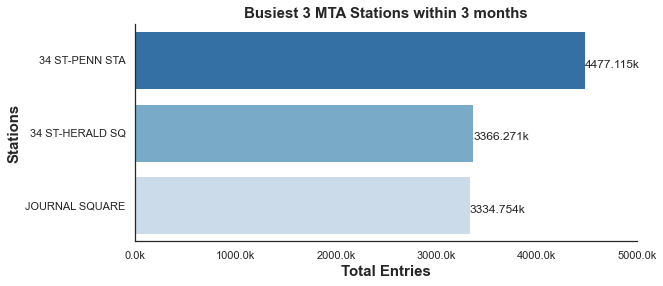

In [361]:
#Plot using seaborn and matplotlib
plt.figure(figsize=[9,4])
sns.set() 
sns.set_style("white")
ax = sns.barplot(data=three_Top_stations,x='DAILY_ENTRIES',y='STATION',palette='Blues_r')
plt.xlabel('Total Entries',weight='bold',fontsize=15)
plt.ylabel('Stations',weight='bold',fontsize=15)
plt.xticks(range(0,5477115,1000000),[str(float(i/1000))+'k' for i in range(0,5477115,1000000)])
plt.title('Busiest 3 MTA Stations within 3 months', weight='bold',fontsize='15',loc='CENTER')
for p in ax.patches:
        ax.annotate(str(float(p.get_width()/1000))+'k', (p.get_width(), p.get_y()+0.5))
sns.despine()

#To save the plot
plt.savefig('barplot_Busiest.png',transparent=True, bbox_inches='tight')

    -Plotting the top 3 stations across the week from 03/7/2021 to 02/10/2021 :

* Plot 1 (Bar chart) :

    -Plot for 34 ST-PENN STA station :

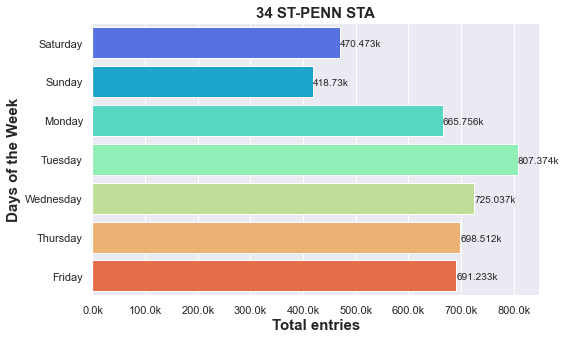

In [341]:
plt.figure(figsize=[8,5])
ax = sns.barplot(data=mask_week_day[7:14],x='DAILY_ENTRIES',y='WEEK_DAY',palette='rainbow')
plt.xlabel('Total entries',weight='bold',fontsize=15)
plt.ylabel('Days of the Week',weight='bold',fontsize=15)
plt.xticks(range(0,807374,100000),[str(float(i/1000))+'k' for i in range(0,807374,100000)])
plt.title('34 ST-PENN STA', weight='bold',fontsize='15')
for p in ax.patches:
        ax.annotate(str(float(p.get_width()/1000))+'k', (p.get_width(), p.get_y()+0.5))
sns.despine()

#To save the plot
plt.savefig('barplot2.png',transparent=True, bbox_inches='tight')

    -Plot for 34 ST-HERALD SQ station :

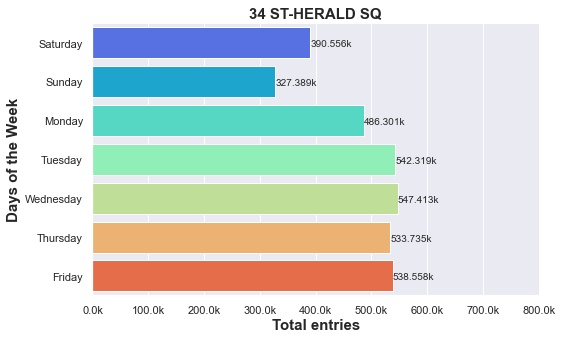

In [337]:
plt.figure(figsize=[8,5])
ax = sns.barplot(data=mask_week_day[:7],x='DAILY_ENTRIES',y='WEEK_DAY',palette='rainbow')
plt.xlabel('Total entries',weight='bold',fontsize=15)
plt.ylabel('Days of the Week',weight='bold',fontsize=15)
plt.xticks(range(0,807374,100000),[str(float(i/1000))+'k' for i in range(0,807374,100000)])
plt.title('34 ST-HERALD SQ', weight='bold',fontsize='15')
for p in ax.patches:
        ax.annotate(str(float(p.get_width()/1000))+'k', (p.get_width(), p.get_y()+0.5))
sns.despine()

#To save the plot
plt.savefig('barplot2.png',transparent=True, bbox_inches='tight')

    -Plot for JOURNAL SQUARE station :

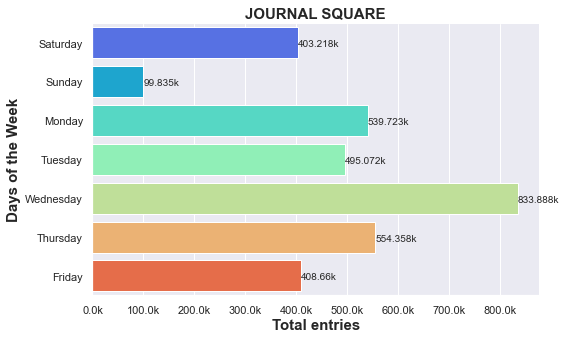

In [335]:
plt.figure(figsize=[8,5])
ax = sns.barplot(data=mask_week_day[14:],x='DAILY_ENTRIES',y='WEEK_DAY',palette='rainbow')
plt.xlabel('Total entries',weight='bold',fontsize=15)
plt.ylabel('Days of the Week',weight='bold',fontsize=15)
plt.xticks(range(0,807374,100000),[str(float(i/1000))+'k' for i in range(0,807374,100000)])
plt.title('JOURNAL SQUARE', weight='bold',fontsize='15')
for p in ax.patches:
        ax.annotate(str(float(p.get_width()/1000))+'k', (p.get_width(), p.get_y()+0.5))
sns.despine()

#To save the plot
plt.savefig('barplot2.png',transparent=True, bbox_inches='tight')

* Plot 2 (Heatmap) for all top 3 stations :

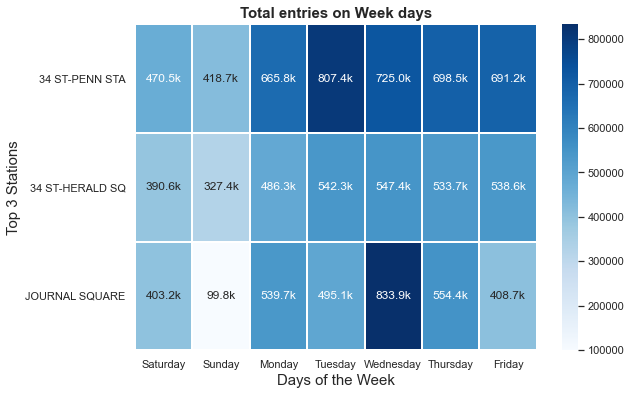

In [362]:
stations_order=['34 ST-PENN STA','34 ST-HERALD SQ','JOURNAL SQUARE']
Stations_Entries_Week = mask_week_day.pivot("STATION", "WEEK_DAY", "DAILY_ENTRIES").reindex(days_order, axis=1).reindex(stations_order, axis=0)

# Draw a heatmap with the numeric values in each cell
array = np.array(Stations_Entries_Week.applymap(lambda x:str(round(x/1000,1))+'k'))
sns.set() 
sns.set_style("white")
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(Stations_Entries_Week, annot=array, linewidths=1, ax=ax,cmap="Blues",fmt='',linecolor='white')
plt.yticks(rotation=0) 
plt.xlabel('Days of the Week',fontsize=15)
plt.ylabel('Top 3 Stations',fontsize=15)   
plt.title('Total entries on Week days',weight='bold',fontsize=15)
plt.savefig('heatmap.png',transparent=True, bbox_inches='tight')

## 4.Communicate results

1-The outcome is depicted in bar chart, where the bar chart displays the names of stations on the vertical axis and the number of entries within three months at these stations on the horizontal axis. Which displays the busiest 3 stations. This result after doing EDA on MTA data indicates that 24 ST-PENN STA is the most frequented station, followed by 34 ST-HERALD SQ, and then JOURNAL SQUARE. I recommend Moburst Advertising to place their billboards in these three stations.

2-In the heat map shows the total entries for each day of the week at the top three busiest stations.That will be useful for Moburst advertising company to determining the price of the advertisements based on the result on  a heat map.